# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━

In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 11.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 2.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
  Attempting uninstall: dask
    Found existing installation: dask 2024.2.0
    Uninstalling dask-2024.2.0:
      Successfully uninstalled dask-2024.2.0
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.2.0
    Uninstalling distributed-2024.2.0:
      Successfully uninstalled distributed-2024.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts

In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal.pkl") 
variables = open('./ModeloFinal.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'count_date_receiver_distinct', 'branch_has_fraud', 
    'receiver_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']
    

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
testeo = testeo.astype(convert_dict)

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()

In [15]:
corte

6.618727226617136e-08

In [16]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [17]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
testeo = testeo.astype(convert_dict)

In [18]:
testeo['target'].value_counts(dropna=False)

target
False    26478152
True          759
Name: count, dtype: int64

In [19]:
Y_target.shape

(26478911, 8)

In [20]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [21]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [22]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,26478147,5
1,219,540


In [23]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,26367669,110483
1,46,713


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

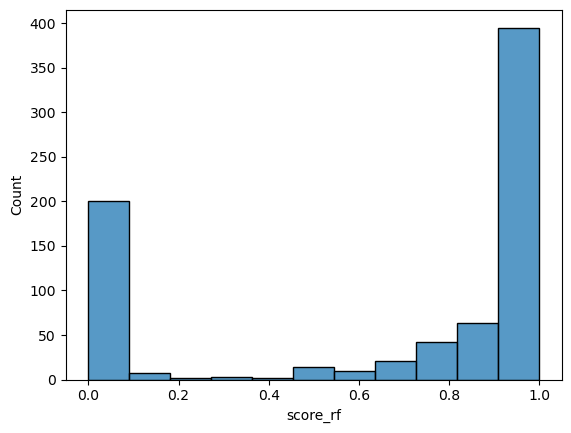

In [24]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [25]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9762845849802372


In [26]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,264059,731
2,264783,6
3,264785,4
4,264786,3
5,264786,3
...,...,...
96,264789,0
97,264789,0
98,264789,0


In [27]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.462399e-08  1.000000e+00
2             4.415688e-09  1.462384e-08
3             2.218055e-09  4.415687e-09
4             1.362281e-09  2.218051e-09
5             9.336150e-10  1.362279e-09
...                    ...           ...
96            3.295814e-13  3.912198e-13
97            2.680583e-13  3.295814e-13
98            2.045854e-13  2.680579e-13
99            1.352513e-13  2.045851e-13
100           3.108735e-15  1.352512e-13

[100 rows x 2 columns]

In [28]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,37959,34339,33250,32730,40894,45276,40342
2,37481,32821,31057,31168,42545,47919,41798
3,37487,32444,30359,30582,42752,48863,42302
4,37433,31828,29763,29967,43411,49750,42637
5,37476,31824,29712,29745,43575,49428,43029
6,37563,31701,29164,29632,43599,50011,43119
7,37566,31380,29027,29398,43868,50308,43242
8,37569,31182,28872,29442,44425,50031,43268
9,37704,31623,28675,29230,44103,49996,43458


In [29]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [30]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [31]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,1676,64
2,1785,34
3,2103,22
4,2105,60
5,2019,44
6,2428,67
7,2089,30
8,2161,37
9,2643,28


In [32]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,3379,64
2,3626,34
3,4223,22
4,4148,60
5,4170,44
6,4895,67
7,4246,30
8,4404,37
9,5152,33


In [33]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,5075,64
2,5482,34
3,6357,22
4,6197,60
5,6266,44
6,7399,67
7,6419,30
8,6621,37
9,7650,36


In [34]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['targetF'])

targetF,False,True
mes,,
1,6871,64
2,7360,34
3,8383,22
4,8187,60
5,8370,44
6,9909,67
7,8629,30
8,8832,37
9,10199,37


## Curva ROC y FP

In [35]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [36]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.920945244539636
ROC FRAUD TESTEO:
0.9676106647312758


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9560081962416914
Precision FRAUD TESTEO:
0.006412101154717796
Recall FRAUD TESTEO:
0.9393939393939394


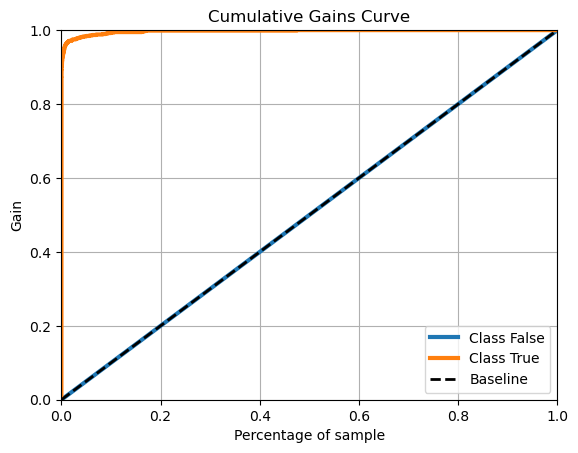

In [37]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


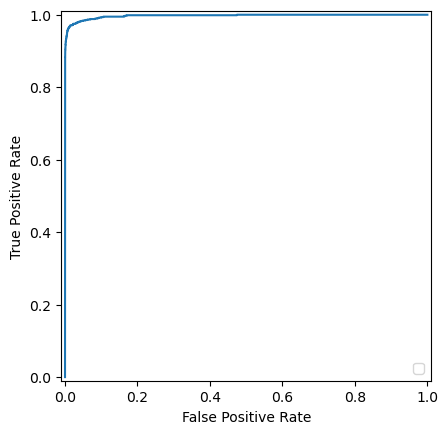

In [38]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

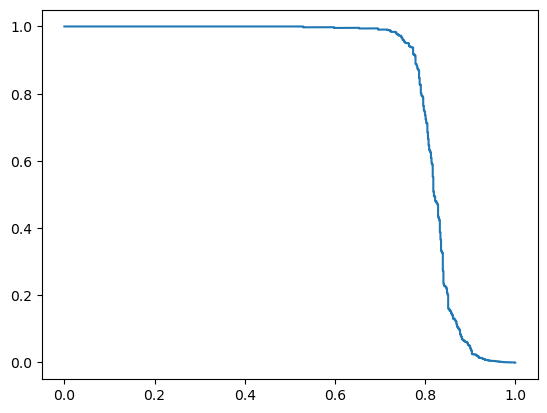

In [39]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [40]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.800266311584554

## Monthly analysis

In [41]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,1717210,118
2,1765411,58
3,2030724,44
4,2116204,87
5,2289892,69
6,2193663,101
7,2314224,50
8,2296945,68
9,2420668,75


In [42]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,6817,118
2,7336,58
3,8362,43
4,8161,86
5,8346,68
6,9878,98
7,8609,50
8,8801,68
9,10177,59


In [43]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [44]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16740,17123,17191,17400,17420,17513,17435,17553,17667,17584,17611,17929,17763,17715,17583,17812,17904,17871,17905,17955,18046,17862,18070,17731,18011,17857,18133,17853,17982,17914,17811,18082,17982,17888,18144,17892,18055,18034,17963,18061,17872,17991,17843,18013,18045,17912,17771,17813,17786,17975,17887,17623,17725,17761,17718,17830,17726,17609,17661,17669,17537,17683,17685,17851,17511,17365,17298,17505,17227,17264,17383,17270,17194,17058,17113,16906,16824,16959,16877,16637,16428,16552,16211,16453,16291,15925,15984,15654,15567,15503,15260,15375,15214,14770,14791,14436,14279,14080,13507,12626
2,17405,17393,17598,17432,17648,17807,17936,17849,17822,17666,18051,18092,17883,17973,17829,18069,18148,17889,18138,18073,17988,17980,18121,18253,18102,18188,18022,18387,18012,18232,17873,18140,18216,18388,18235,18318,18380,18265,18050,18147,18170,18280,18121,18282,18187,18222,18047,18281,18240,18060,17693,18031,17976,18025,18171,17951,18023,18171,18101,18125,18028,17817,17937,18051,17910,17828,17621,17861,17857,17739,17672,17567,17571,17395,17620,17548,17633,17424,17196,17141,17454,17249,17006,17031,16851,16912,16690,16969,16830,16540,16670,16584,16331,16286,16174,16174,15946,15812,15683,14706
3,19662,18955,18927,18748,18995,18770,19195,19188,19031,19100,18957,18978,19244,19182,19209,19173,19364,19157,19271,19180,19333,19228,19404,19303,19431,19634,19241,19496,19501,19668,19498,19538,19654,19449,19545,19531,19643,19788,19906,19512,19646,19667,19783,19738,19670,19709,19728,19602,19716,19860,20012,20170,20113,19854,19796,20046,20011,20201,20026,19885,19993,20027,20293,20210,20260,20246,20558,20381,20556,20361,20352,20548,20626,20663,20639,20609,20700,20933,20868,20834,21191,21156,21266,21119,21388,21302,21563,21615,21742,22027,21942,22281,22278,23165,23009,23305,23905,24583,25765,26687
4,19289,19233,19180,19492,19338,19217,19706,19775,19873,19649,19734,19722,19944,19879,19992,20039,19971,20205,20149,20040,20377,20250,20341,20067,20487,20393,20438,20560,20599,20313,20885,20316,20676,20408,20665,20668,20483,20746,20661,20749,20485,21094,21022,20921,20796,20923,20516,20919,21134,20833,20948,21196,20900,21167,21148,21134,21133,21217,21193,21447,21524,21454,21216,21233,21229,21483,21319,21503,21496,21682,21491,21780,21881,21667,21843,21696,21864,21990,22135,22144,21995,22068,22137,22035,22440,22548,22510,22388,22470,22681,22713,22847,23070,23345,23619,23729,24087,24148,24472,23724
5,19989,20199,20613,20449,20723,20881,20871,20789,20690,20685,20863,21105,20844,21003,20868,21146,21170,21185,20918,21098,21200,21158,21426,21310,21285,21132,21336,21251,21465,21529,21686,21489,21245,21346,21548,21644,21359,21507,21564,21773,21587,21846,21665,21727,22047,21534,22071,21851,21797,22039,22014,22111,22279,22251,22589,22254,22218,22338,22327,22817,22584,22633,22631,22512,22807,22677,23093,23110,22932,23173,23416,23450,23478,23583,23501,23572,23691,23789,24054,23949,24349,24324,24284,24480,24935,25057,25374,25420,25525,25491,25923,26469,27096,27011,27876,28740,29339,30357,32300,35272
6,24424,25053,24875,24959,24929,25044,24549,24475,24524,24035,24360,24159,24017,23942,24227,23974,23510,23787,23927,23840,23740,23651,23603,23679,23242,23624,23489,23318,23339,23203,23047,23054,22913,23384,22992,22938,23087,22654,22615,22746,22835,22465,22867,22458,22513,22630,22421,22390,22576,22437,22364,22029,22050,22051,22152,21997,22066,21723,21531,21980,21919,21605,21314,21408,21396,21260,21270,21403,21149,21151,20934,21193,20923,20564,20951,20791,20617,20308,20268,20239,20126,20208,20212,20015,19708,19844,19256,19240,19212,19052,18915,18433,18642,18144,17897,17584,175

In [45]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,17,18,48
mes,,,,,,,,,,,,,,
1,118,0,0,0,0,0,0,0,0,0,0,0,0,0
2,58,0,0,0,0,0,0,0,0,0,0,0,0,0
3,43,0,0,0,0,0,0,0,1,0,0,0,0,0
4,86,0,1,0,0,0,0,0,0,0,0,0,0,0
5,68,1,0,0,0,0,0,0,0,0,0,0,0,0
6,100,0,0,0,0,0,0,1,0,0,0,0,0,0
7,50,0,0,0,0,0,0,0,0,0,0,0,0,0
8,68,0,0,0,0,0,0,0,0,0,0,0,0,0
9,65,2,1,1,1,1,0,0,0,0,1,1,1,1


In [46]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
25964,2,Distraction,1
81903,8,Real,1
97248,5,Distraction,1
98717,6,Real,1
99988,4,Distraction,1
...,...,...,...
25072538,12,Real,1
25198423,12,Real,1
25296256,12,Real,1
25369488,12,Real,1


# Monthly indicators

In [47]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        summary_metrics.loc[i,'month'] = m
        summary_metrics.loc[i,'year'] = y
        summary_metrics.loc[i,'precision'] = precision
        summary_metrics.loc[i,'recall'] = recall
        summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte'].sum()
        summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
        summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
        #print ('Year:', y, 'Month:',m)
        #print ('Precision:', precision, 'Recall:',recall)
        i = i+1
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.009229,1.0,6935,118,64,64
0,2,2023,0.004598,1.0,7394,58,34,34
5,3,2023,0.002617,1.0,8405,44,22,22
1,4,2023,0.007275,0.983607,8247,87,61,60
2,5,2023,0.005229,0.977778,8414,69,45,44
3,6,2023,0.006716,0.957143,9976,101,70,67
4,7,2023,0.003465,1.0,8659,50,30,30
7,8,2023,0.004172,1.0,8869,68,37,37
8,9,2023,0.003615,0.840909,10236,75,44,37
9,10,2023,0.002091,0.78125,11958,46,32,25


In [48]:
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.009229,1.0,6935,118,64,64
0,2,2023,0.004598,1.0,7394,58,34,34
5,3,2023,0.002617,1.0,8405,44,22,22
1,4,2023,0.007275,0.983607,8247,87,61,60
2,5,2023,0.005229,0.977778,8414,69,45,44
3,6,2023,0.006716,0.957143,9976,101,70,67
4,7,2023,0.003465,1.0,8659,50,30,30
7,8,2023,0.004172,1.0,8869,68,37,37
8,9,2023,0.003615,0.840909,10236,75,44,37
9,10,2023,0.002091,0.78125,11958,46,32,25


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


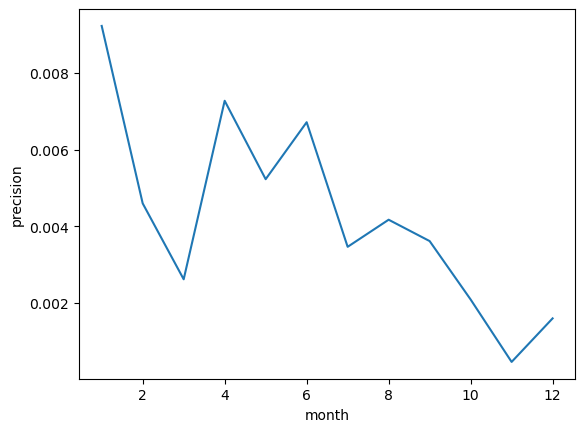

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


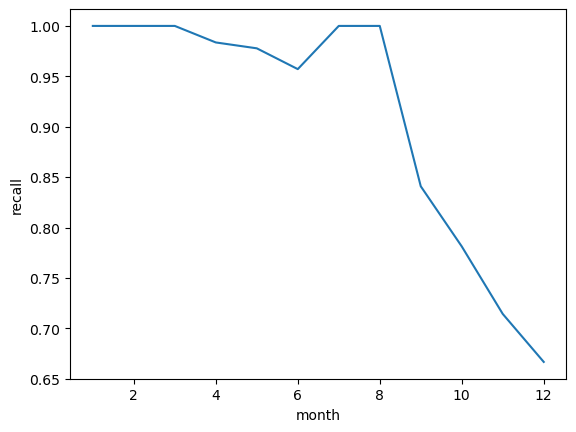

In [49]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [55]:
tes_corte_01['date_receiver'].dt.floor('d')

121        2023-03-22
312        2023-05-27
1652       2023-01-21
2855       2023-07-02
2955       2023-06-25
              ...    
26471979   2023-12-27
26473221   2023-12-10
26474314   2023-12-29
26474945   2023-12-16
26478642   2023-12-20
Name: date_receiver, Length: 27932, dtype: datetime64[ns]

In [58]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [68]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
FRAUDES.to_csv ('./fraudes.csv')

In [69]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2023-12-27,56459,0
2023-12-28,61514,0
2023-12-29,98627,1


In [67]:
Y_c

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03
0,True,False,False,False,False,False,False,False,False,1.109983e-12,False,86,None,False,False,False,False
1,False,True,False,False,False,False,False,False,False,4.692525e-12,False,63,None,False,False,False,False
2,False,False,False,False,True,False,False,False,False,1.964715e-11,False,38,None,False,False,False,False
3,False,False,False,False,False,False,True,False,False,1.979412e-13,False,99,None,False,False,False,False
4,False,False,False,False,False,False,True,False,False,4.144079e-12,False,65,None,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26478906,False,False,False,False,False,False,True,False,False,1.387339e-12,False,83,None,False,False,False,False
26478907,False,False,False,False,False,False,True,False,False,8.353207e-12,False,52,None,False,False,False,False
26478908,True,False,False,False,False,False,False,False,False,4.596347e-10,False,8,None,False,False,False,False
26478909,False,False,False,True,False,False,False,False,False,1.862481e-11,False,39,None,False,False,False,False
